<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/portfolio/momentum_portfolio_manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install riskfolio-lib --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 28.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.26.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompat

In [7]:
import riskfolio as rp

In [2]:
#import riskfolio as rp
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import yfinance as yf
import numpy as np

def get_nifty50_tickers():
    data = pd.read_csv('/content/ind_nifty500list.csv', sep=',')
    nifty100 = data['Symbol'].apply(lambda x: x + ".NS").tolist()
    return nifty100

def fetch_stock_data(symbols, start_date, end_date):
    stock_data = yf.download(symbols, start=start_date, end=end_date)['Close']
    return stock_data

nifty50_tickers = get_nifty50_tickers()

start_date = '2022-11-01'
end_date = '2024-03-01'

rolling_periods = [21, 63, 126, 262]
min_data_length = max(rolling_periods)

# Pre-allocate DataFrame
df = pd.DataFrame(columns=['Symbol', 'Close'] + [f'returns_{p}' for p in rolling_periods])

# Fetch data for all tickers at once
stock_data = fetch_stock_data(nifty50_tickers, start_date, end_date)

for i, symbol in enumerate(nifty50_tickers):
    if len(stock_data[symbol]) >= min_data_length:
        closes = stock_data[symbol]
        returns = np.stack([
            closes.rolling(period).apply(lambda x: x[-1] / x[0] - 1)
            for period in rolling_periods
        ], axis=1)

        df.loc[i] = [symbol, closes.iloc[-1]] + returns[-1].tolist()

[*********************100%%**********************]  501 of 501 completed


In [3]:
# Calculate composite scores and ranks
df['Composite Score'] = df[[f'returns_{p}' for p in rolling_periods]].mean(axis=1)
df['Rank'] = df['Composite Score'].rank(ascending=False, method='dense')

In [5]:
# Sort by Composite Score in descending order
df = df.sort_values(by=['Composite Score'], ascending=False)

# Assign ranks based on sorted order
#df['Rank'] = np.arange(len(df)) + 1

# Display the results (top 10 only)
print(df[['Symbol', 'Composite Score', 'Rank']].head(10))

            Symbol  Composite Score  Rank
234        IRFC.NS         1.687739   1.0
212       HUDCO.NS         1.496065   2.0
303        MRPL.NS         1.429582   3.0
321        NBCC.NS         1.330889   4.0
51          BSE.NS         1.327060   5.0
444  TATAINVEST.NS         1.320832   6.0
430      SUZLON.NS         1.257656   7.0
339     OLECTRA.NS         1.173090   8.0
248        JBMA.NS         1.160219   9.0
222       IRCON.NS         1.129424  10.0


In [8]:
assets=df['Symbol'].head(10).tolist()
Uc_assets = [x.upper() for x in assets]


In [9]:
assets_dataframe=yf.download(assets,start=start_date,end=end_date)['Close']
Y= assets_dataframe[Uc_assets].pct_change().dropna()

[*********************100%%**********************]  10 of 10 completed


In [10]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'UCI' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)


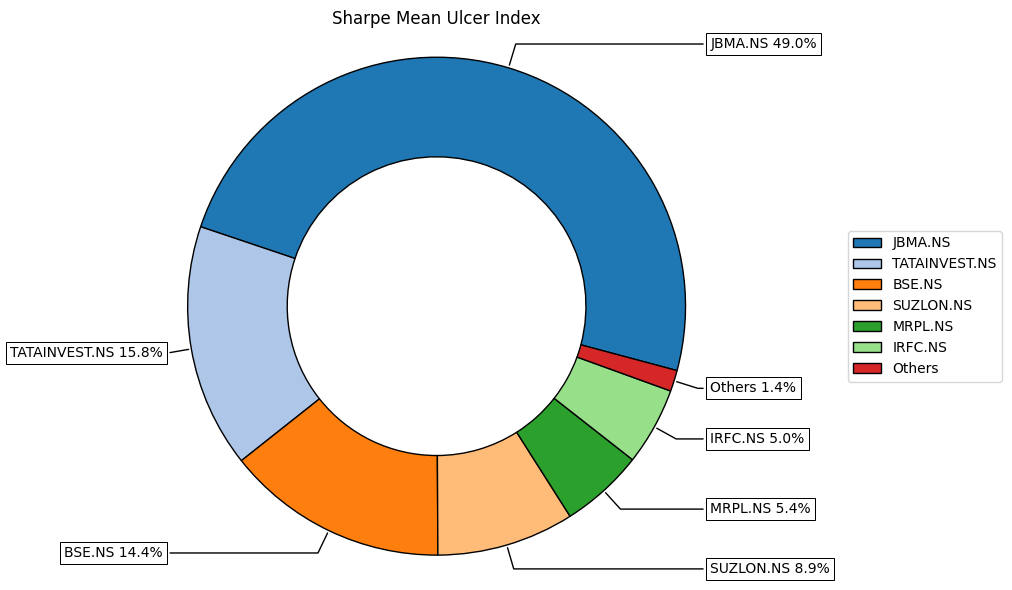

In [11]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Ulcer Index', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

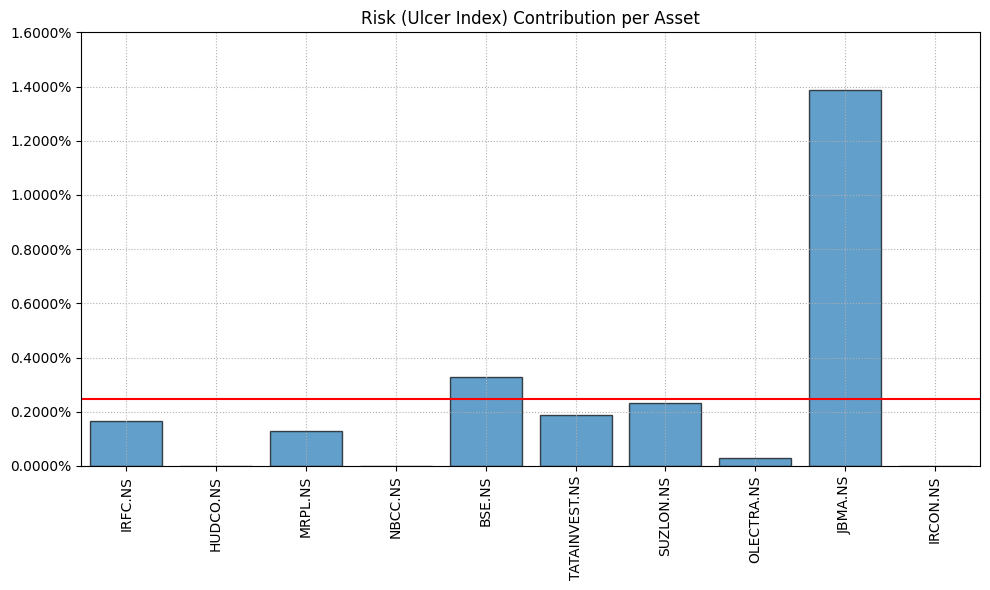

In [12]:
ax = rp.plot_risk_con(w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

[*********************100%%**********************]  10 of 10 completed


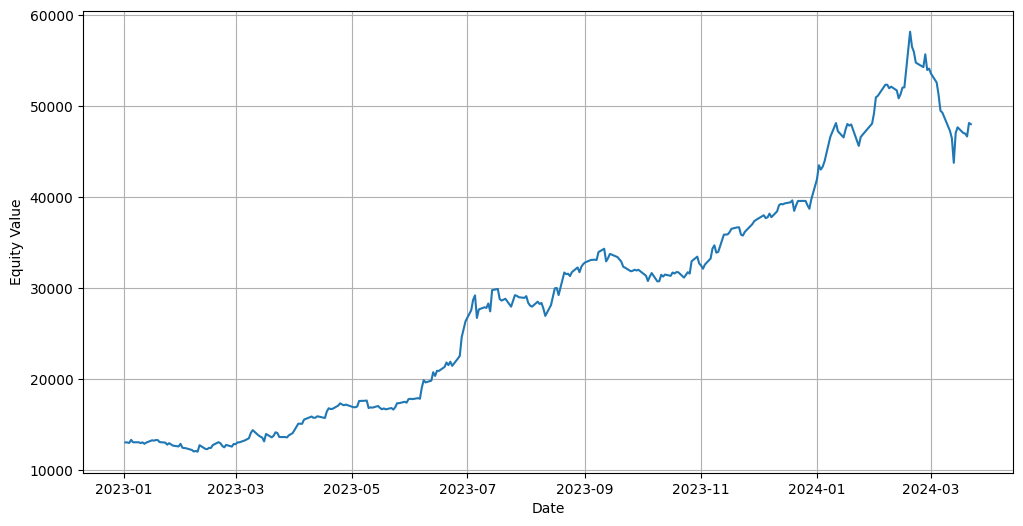

In [23]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# Get today's date
today = pd.Timestamp.today().strftime('%Y-%m-%d')

# Define stock symbols and weights
symbols = assets
weights = list((w.weights)*100)
# Download historical price data
data = yf.download(symbols, start="2023-01-01")["Adj Close"]

# Calculate portfolio return by multiplying weights with daily returns
portfolio_return = (data * weights).sum(axis=1)

# Plot the portfolio return
plt.figure(figsize=(12, 6))
plt.plot(portfolio_return)
plt.ylabel("Equity Value")
plt.xlabel("Date")
plt.grid(True)
plt.show()

[*********************100%%**********************]  10 of 10 completed


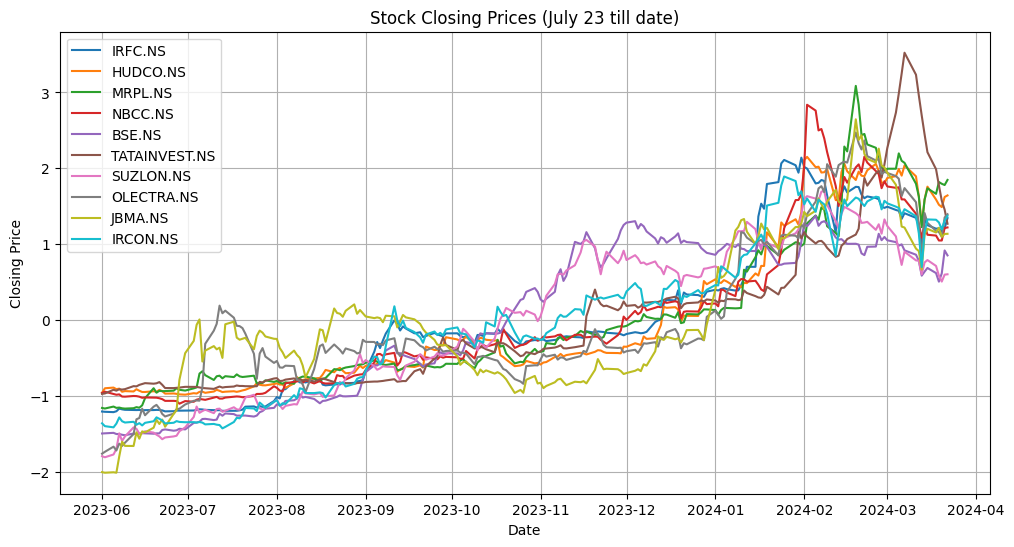

In [24]:
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
# Your list of stock tickers
tickers = assets

# Start and end dates for data retrieval
start_date = datetime.date(2023, 6, 1)


# Download closing price data for each ticker
data = yf.download(tickers, start=start_date)['Adj Close']
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the data
data_scaled = scaler.fit_transform(data)

# Convert back to a DataFrame for plotting
data_scaled = pd.DataFrame(data_scaled, index=data.index, columns=data.columns)
# Plot the closing prices
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
for ticker in tickers:
    plt.plot(data.index, data_scaled[ticker], label=ticker)

plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Stock Closing Prices (July 23 till date)")
plt.legend()
plt.grid(True)
plt.show()